In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
import re

In [4]:
sales = pd.read_csv('../data/interim/sales_train_etl.csv')
shops = pd.read_csv('../data/interim/shops_etl.csv')
items = pd.read_csv('../data/interim/items_etl.csv')
item_cat = pd.read_csv('../data/interim/item_categories_etl.csv')

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,06.01.2013,0,25,2554,1709.05,1.0
3,15.01.2013,0,25,2555,1099.00,1.0
4,10.01.2013,0,25,2564,349.00,1.0


### Sales - date and date block

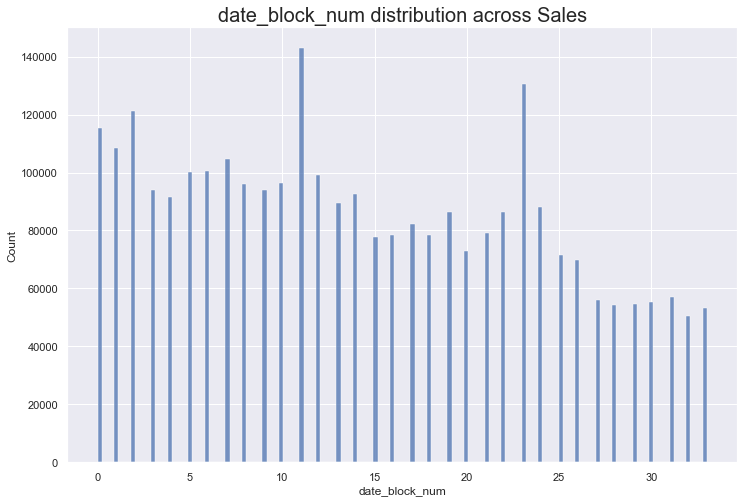

In [156]:
sns.countplot(data=sales, x='date_block_num')
data_viz = df.groupby(['year','transaction_type','tier'], as_index=False)['no_of_purchases'].sum()

sns.catplot(data=data_viz, x='year', y='no_of_purchases', hue='tier', col='transaction_type', kind='bar')
plt.title('date_block_num distribution across Sales', fontsize=20);

По количеству продаж в каждый месяц наблюдается общий тренд на снижение, но есть выбросы на значениях *11* и *23* - эти значения соответсвуют декабрю. Еще можно заметить небольшие подъемы на значениях, соответсвующих августу и марту.

Проанализируем по остальным месяцам и дням недели:

In [158]:
sales['date'] = pd.to_datetime(sales['date'], format="%d.%m.%Y")

sales['month'] = sales['date_block_num'] % 12 + 1
sales['year'] = sales['date'].dt.year
sales['day_of_week'] = sales['date'].dt.dayofweek

#### Month

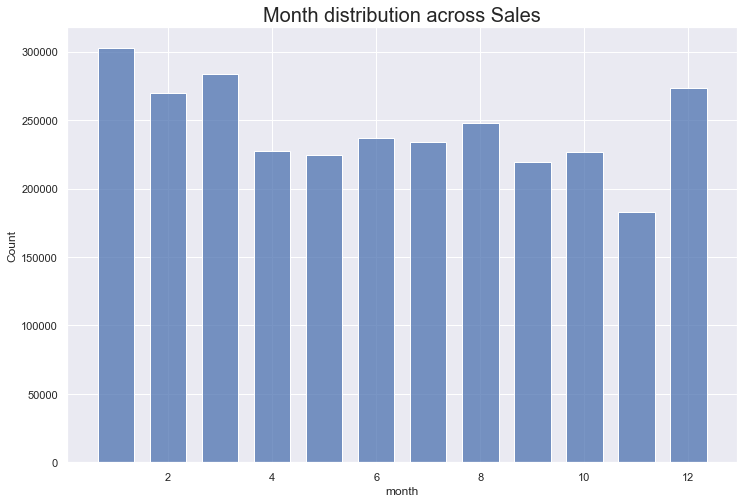

In [159]:
sns.histplot(data=sales, x='month',discrete=True, shrink=.7);
plt.title('Month distribution across Sales', fontsize=20);

Здесь график получается немного искаженный, потому что за последний год у нас есть данные только до октября. Если брать только полные два года, то лучше виден рост продаж в декабре.

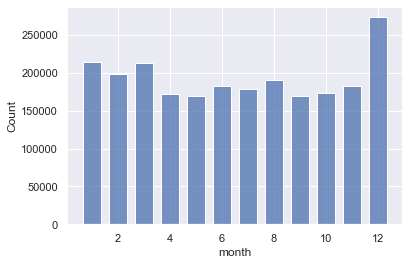

In [89]:
sns.histplot(data=sales[sales['year'] < 2015], x='month',discrete=True, shrink=.7);

#### Day of week

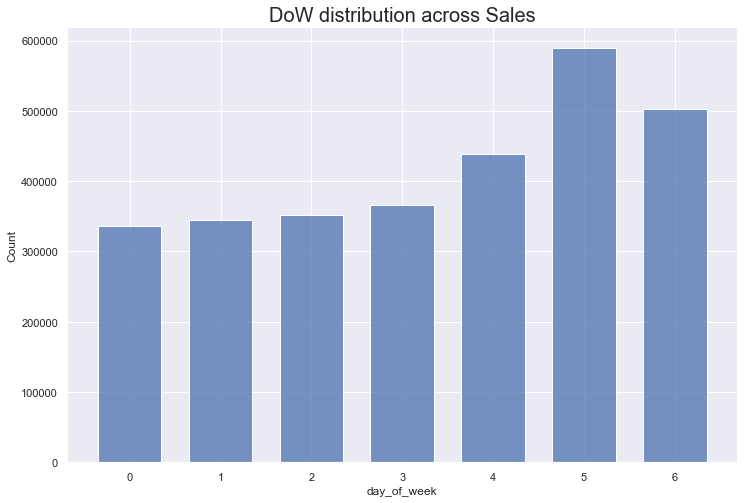

In [160]:
sns.histplot(data=sales, x='day_of_week', discrete=True, shrink=.7)
sns.set(rc={'figure.figsize':(6,4)})
plt.title('DoW distribution across Sales', fontsize=20);

In [137]:
sales.drop(['year','month','day_of_week'],inplace=True, axis=1)

Больше всего покупок совершают на выходных.

### shops and items

In [70]:
sales_merged = sales.merge(shops, on='shop_id').merge(items, on='item_id').merge(item_cat, on='item_category_id')

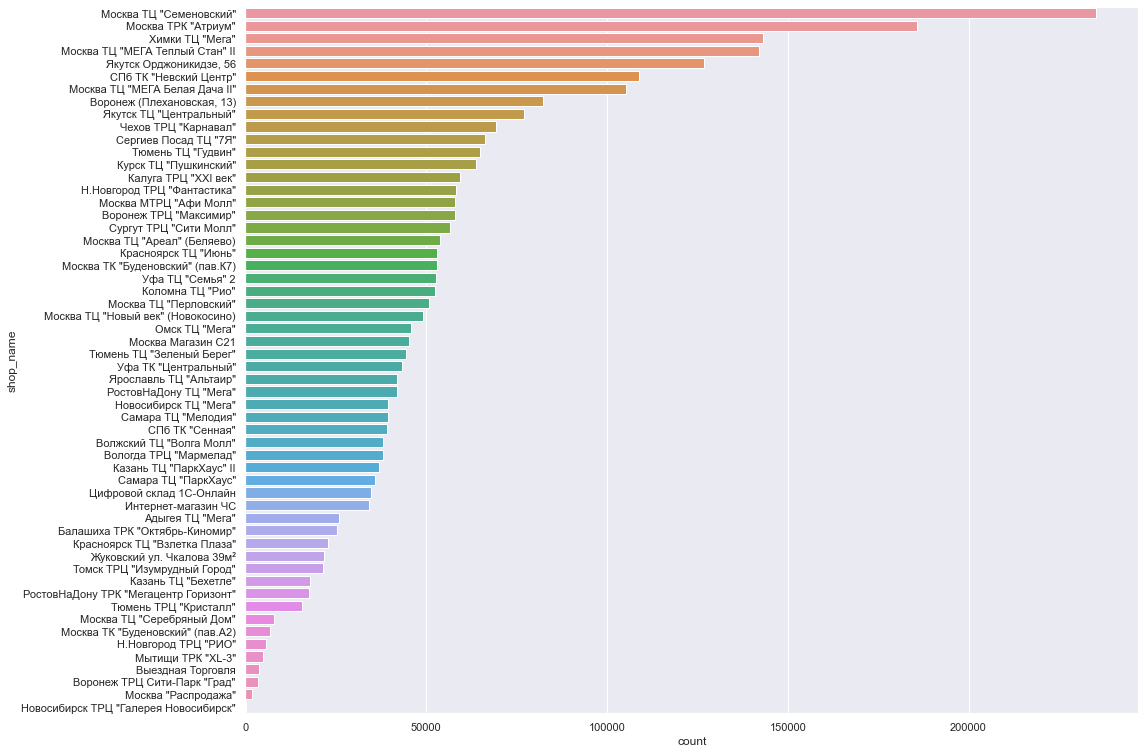

In [171]:
sns.set(rc={'figure.figsize':(16,13)})
sns.countplot(data=sales_merged, y="shop_name", order = sales_merged['shop_name'].value_counts().index);

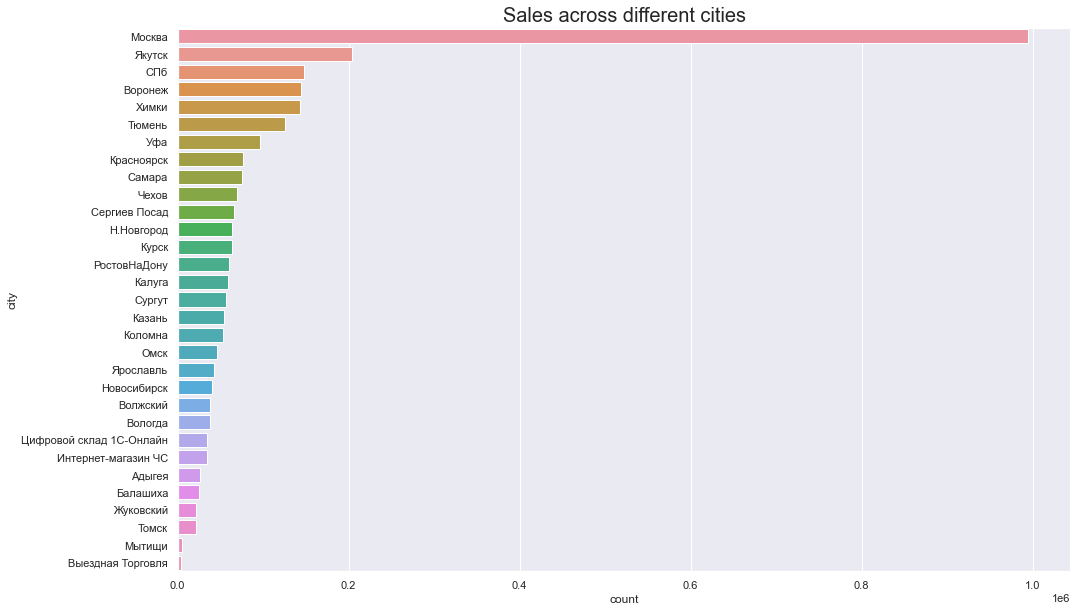

In [174]:
sales_merged['city'] = sales_merged['shop_name'].apply(lambda s: re.split(' (ТРЦ|ТЦ|ТК|ТРК|МТРЦ|\(|\"|ул)',s)[0])
sales_merged['city'].replace({'Якутск Орджоникидзе, 56': 'Якутск', 'Москва Магазин С21': 'Москва'}, inplace=True)

sns.set(rc={'figure.figsize':(16,10)})
sns.countplot(data=sales_merged, y="city", order = sales_merged['city'].value_counts().index);
plt.title('Sales across different cities', fontsize=20);

<AxesSubplot:xlabel='shop_id', ylabel='city'>

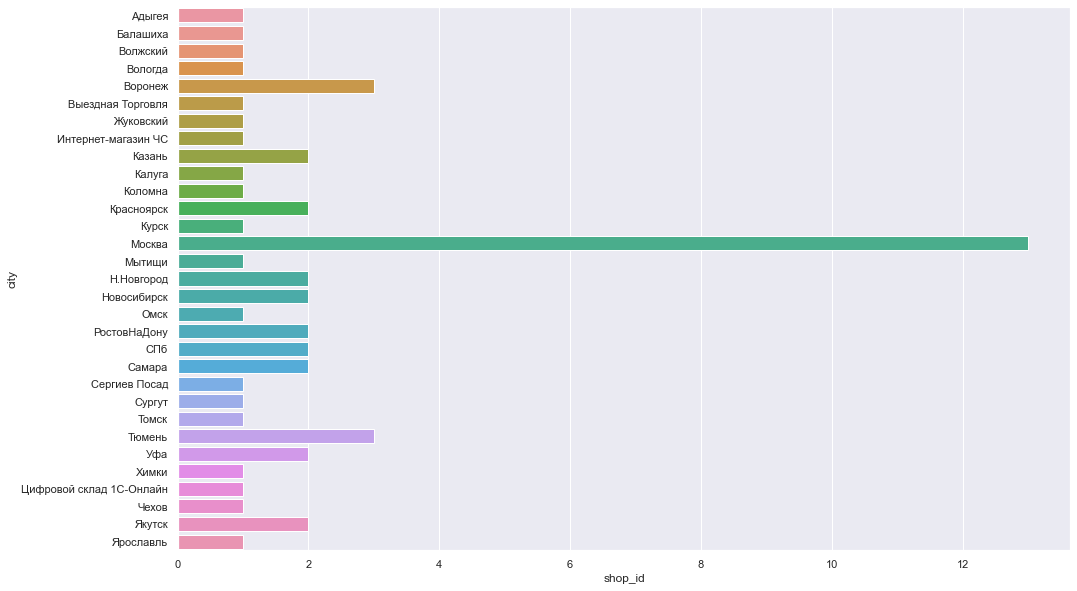

In [175]:
sns.barplot(data=sales_merged.groupby('city')['shop_id'].nunique().reset_index(),y='city', x='shop_id')
plt.title('Shops across different cities', fontsize=20);

Разных предметов слишком много, чтобы отобразить в одном графике, но можно рассмотреть категории. Можно заметить, что большинство категорий состоит из двух частей, разделенных дефисом, из которых первая - более глобальная.

In [113]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


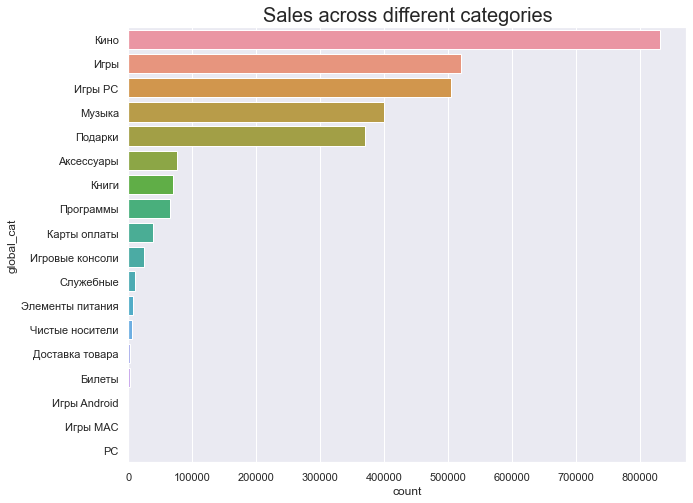

In [186]:
sales_merged['global_cat'] = sales_merged['item_category_name'].apply(lambda s: re.split(' (-|\()', s)[0])

sns.countplot(data=sales_merged, y="global_cat", order = sales_merged['global_cat'].value_counts().index);
plt.title('Sales across different categories', fontsize=20);

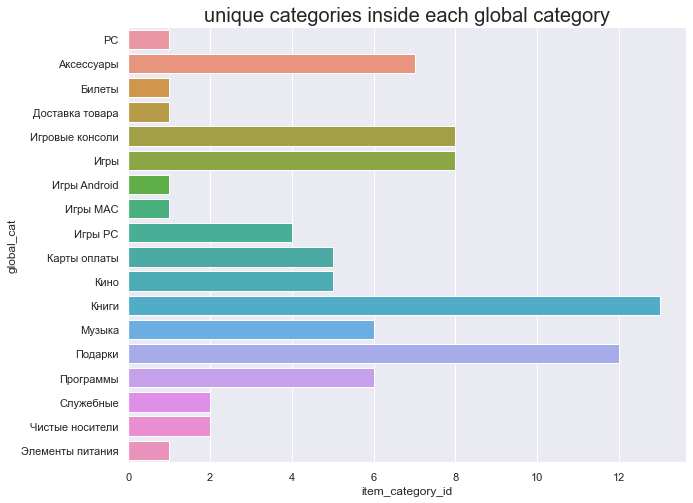

In [184]:
sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(data=sales_merged.groupby('global_cat')['item_category_id'].nunique().reset_index(),y='global_cat', x='item_category_id')
plt.title('unique categories inside each global category', fontsize=20);

#### price and item count

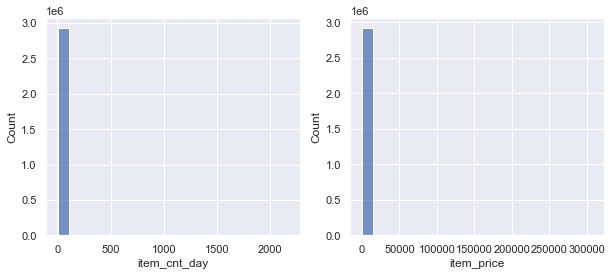

In [128]:
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(10,4)})
sns.histplot(data=sales, x='item_cnt_day', bins=20, ax=axs[0]);
sns.histplot(data=sales, x='item_price', bins=20, ax=axs[1]);
sns.set(rc={'figure.figsize':(10,4)})

Из-за выбросов, которые решили не удалять на ETL, получаются такие нерепрезентативные графики, можно попробовать откинуть последние 1-2% значений.

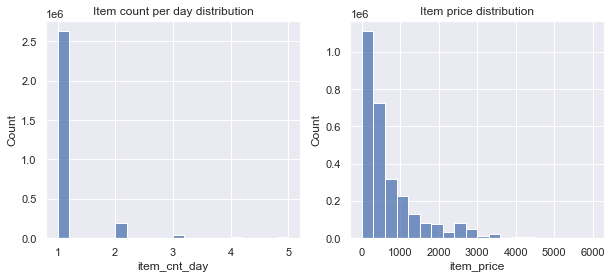

In [163]:
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(10,4)})
sns.histplot(data=sales[sales['item_cnt_day'] <= sales['item_cnt_day'].quantile(.99)], x='item_cnt_day', bins=20, ax=axs[0]).set(title='Item count per day distribution');
sns.histplot(data=sales[sales['item_price'] <= sales['item_price'].quantile(.99)], x='item_price', bins=20, ax=axs[1]).set(title='Item price distribution');

### actually monthly sales

In [146]:
monthly_sales = sales.groupby(by=['date_block_num', 'shop_id', 'item_id']).sum().reset_index().drop(['item_price'], axis=1)
monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

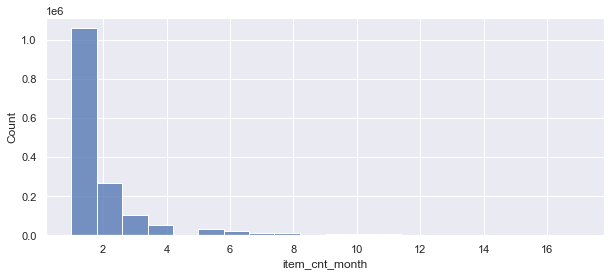

In [148]:
sns.histplot(data=monthly_sales[monthly_sales['item_cnt_month'] <= monthly_sales['item_cnt_month'].quantile(.99)], 
             x='item_cnt_month', bins=20);

In [164]:
sales_merged.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'month', 'year', 'day_of_week', 'shop_name',
       'item_name', 'item_category_id', 'item_category_name', 'city',
       'global_cat'],
      dtype='object')

In [188]:
competitions1 = [[2012, i] for i in range(1000)]
competitions2 = [[2013, i] for i in range(1000)]
comp = competitions1 + competitions2

In [192]:
dic = {c[0] : [] for c in comp}

In [193]:
dic

{2012: [], 2013: []}